A Jupyter Widget

A Jupyter Widget

<IPython.core.display.Javascript object>


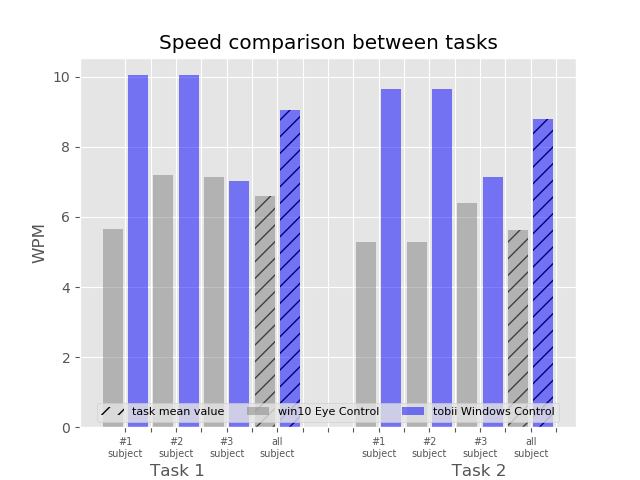

In [73]:
%matplotlib notebook	
import csv
from __future__ import print_function
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
import numpy as np
import seaborn as sns


# create Sentence class
class Sentence:
	# class variable shared by all instances
	def __init__(self, subject, task, sentenceNo, testing):
		# instance variable unique to each instance
		self.subject = subject
		self.task = task			# 0: transcribe; 1: free conversation
		self.sentenceNo = sentenceNo
		self.testing = testing
		self.P = ""
		self.T = ""
		self.IS = ""
		self.wpm = 0.0
		self.totErrRate = 0.0
		self.keyboard = 0	# 0: win10 Eye Control; 1: tobii Win Control

def readSentences(argFilename, argSentences):
	with open('RawData/'+argFilename+'.csv') as csvDataFile:
		csvReader = csv.reader(csvDataFile)
		next(csvReader, None)
		next(csvReader, None)
		for row in csvReader:
			# write on keyboard clasification
			if 'Transcribe' in argFilename:
				argSentences.append(Sentence(int(argFilename[0])-1, 0, int(row[0]), int(row[1])))
			elif 'FreeConv' in argFilename:
				argSentences.append(Sentence(int(argFilename[0])-1, 1, int(row[0]), int(row[1])))
			# handle exceptions
			# if test subject didn't enter anything and skipped this sentence
			if int(row[2]) != 0:
				sentences[-1].wpm = int(row[4])+int(row[5])*0.1**(len(row[5]))
				sentences[-1].totErrRate = int(row[-14])*0.1**(len(row[-14]))
			else:
				sentences[-1].wpm = 0
				sentences[-1].totErrRate = 1
			if 'winEyeControl' in argFilename:
				sentences[-1].keyboard = 0
			elif 'tobiiWinControl' in argFilename:
				sentences[-1].keyboard = 1

def onChange_plotType(b):
	if b['type'] == 'change' and b['name'] == 'value':
		if contrPlotType.value == 'Speed over sentences':
			plots()
			contrKeybd.disabled = True
		elif contrPlotType.value == 'Speed between tasks':
			plotWpmBetweenTasks()
			contrTask.disabled = True
		elif contrPlotType.value == 'Irrelavant variables influence':
			plotInfTaskSubject()
			contrTask.disabled = True
			contrSubject.disabled = True

def onChange_task(change):
	if change['type'] == 'change' and change['name'] == 'value':
		plots()

def onChange_subject(change):
	if change['type'] == 'change' and change['name'] == 'value':
		plots()

def onChange_keybd(change):
	if change['type'] == 'change' and change['name'] == 'value':
		plotInfTaskSubject()

# def delOutliers(argSentenceSet):
# 	print('did not filter')

# read task and subject selection from UI controls, prepare for plotting
def plots():
	print('plots')
	# read subject selection from UI control
	if contrTask.value == 'Transcribe':
		argTask = 0
	elif contrTask.value == 'Free Conversation':
		argTask = 1
	if contrSubject.value != '#All':
		argSubject = int(contrSubject.value[1])-1
		sentenceKeybdA = [item for item in sentences if item.subject == argSubject and item.task == argTask and item.keyboard == 0 and item.testing == 1]
		sentenceKeybdB = [item for item in sentences if item.subject == argSubject and item.task == argTask and item.keyboard == 1 and item.testing == 1]			
	else:
		argSubject = '#All'
		sentencesKeybdA = [item for item in sentences if item.task == argTask and item.keyboard == 0 and item.testing == 1]
		sentencesKeybdB = [item for item in sentences if item.task == argTask and item.keyboard == 1 and item.testing == 1]

	if contrPlotType.value == 'Speed over sentences':
		if argSubject != '#All':
			plotSpeedOverSentences(sentenceKeybdA, sentenceKeybdB, 1, 1)	
		else:
			plotSpeedOverSentences(sentencesKeybdA, sentencesKeybdB, 3, 3)		

# plot TypePerf of 2 keyboards against sentences, with variable variance visualization,
def plotSpeedOverSentences(argSentenceSet0, argSentenceSet1, argCount0, argCount1):
	# print('plotSentences')
	sentenceKeybdA, sentenceKeybdB = ([] for i in range(2))
	counter = 0
	counterTrim = [[0],[0]]
	subject = argSentenceSet0[0].subject
	# read sentences for a keyboard within a task
	for item in argSentenceSet0:
		if argSentenceSet0[counter].subject != subject:
			counterTrim[0].append(counter)
			subject = argSentenceSet0[counter].subject
		counter += 1
	counterTrim[0].append(len(argSentenceSet0))
	for item in counterTrim[0]:
		if item != 0:
			sentenceKeybdA.append(argSentenceSet0[itemTemp:item])
		itemTemp = item
	counter = 0
	for item in argSentenceSet1:
		if argSentenceSet1[counter].subject != subject:
			counterTrim[1].append(counter)
			subject = argSentenceSet1[counter].subject
		counter += 1
	counterTrim[1].append(len(argSentenceSet1))
	for item in counterTrim[1]:
		if item != 0:
			sentenceKeybdB.append(argSentenceSet1[itemTemp:item])
		itemTemp = item

	# handle exceptions when wpm = 0, replace it with gradient
	x_A, y_A, z_A, yMean_A, x_B, y_B, z_B, yMean_B = ([] for i in range(8))
	for itemI in sentenceKeybdA:
		xTemp, yTemp, zTemp = ([] for i in range(3))
		for itemJ in itemI:
			xTemp.append(itemJ.sentenceNo)
			yTemp.append(itemJ.wpm)
			zTemp.append(itemJ.totErrRate)
		x_A.append(xTemp)
		y_A.append(yTemp)
		z_A.append(zTemp)
	for itemI in sentenceKeybdB:
		xTemp, yTemp, zTemp = ([] for i in range(3))
		for itemJ in itemI:
			xTemp.append(itemJ.sentenceNo)
			yTemp.append(itemJ.wpm)
			zTemp.append(itemJ.totErrRate)
		x_B.append(xTemp)
		y_B.append(yTemp)
		z_B.append(zTemp)

	# plot average horizontal line
	length = [0, 0]
	for j in range(2):
		for i in range(len(counterTrim[j])-2):
			if len(y_A[i]) > length[j]:
				length[j] = len(y_A[i])

	for i in range(length[0]):
		yMeanBuffer = []
		for j in range(len(counterTrim[0])-1):
			try:
				yMeanBuffer.append(y_A[j][i])
			except IndexError:
				pass
		yMeanValue = np.mean(yMeanBuffer)
		yMean_A.append(yMeanValue)
	for i in range(length[1]):
		yMeanBuffer = []
		for j in range(len(counterTrim[1])-1):
			try:
				yMeanBuffer.append(y_B[j][i])
			except IndexError:
				pass
		yMeanValue = np.mean(yMeanBuffer)
		yMean_B.append(yMeanValue)

	fig, ax = plt.subplots()
	for i in range(len(sentenceKeybdA)):
		plt.scatter(x_A[i], y_A[i], c=z_A[i])
		plt.scatter(x_B[i], y_B[i], c=z_B[i])
		if argCount0 == 1: 
			plt.plot(x_A[i], y_A[i], 'o-', label='win10 EyeControl', alpha=0.2, color='orange')
			yMeanValue_A = np.mean(y_A[i])
			plt.plot([min(x_A[i]), max(x_A[i])], [yMeanValue_A, yMeanValue_A], '--', label='win10 EyeControl mean', color='orange')
		elif i == 0:
			plt.scatter(x_A[i], y_A[i], color='orange', alpha=0.3, label='win10 EyeControl')
		else:
			plt.scatter(x_A[i], y_A[i], color='orange', alpha=0.3)
		if argCount1 == 1:
			plt.plot(x_B[i], y_B[i], 'o-', label='tobii WinControl', alpha=0.2, color='blue')
			yMeanValue_B = np.mean(y_B[i])
			plt.plot([min(x_B[i]), max(x_B[i])], [yMeanValue_B, yMeanValue_B], '--', label='tobii WinControl mean', color='blue')	
		elif i ==0:
			plt.scatter(x_B[i], y_B[i], color='blue', alpha=0.3, label='tobii WinControl')
		else:
			plt.scatter(x_B[i], y_B[i], color='blue', alpha=0.3)
	if argCount0 != 1:
		plt.plot(range(4, len(yMean_A)+4), yMean_A, '--', label='win10 EyeControl mean', color='orange')
	if argCount1 != 1:
		plt.plot(range(4, len(yMean_B)+4), yMean_B, '--', label='tobii WinControl mean', color='blue')

	# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4)
	ax.legend(loc='upper left')
	ax.set(title='Subject '+contrSubject.value, xlabel='sentence', ylabel='wpm')
	plt.set_cmap('gray')	# high error rate deepen the scatter color
	plt.show()

def plotWpmBetweenTasks():
	# sentenceTask1=[[sentences for task0],[sentences for task1]]
	sentenceTask0, sentenceTask1 = ([] for i in range(2))
	# 3 subjects, so tempSentenceTask0 = [[]*3]
	tempSentenceTask0Keybd0, tempSentenceTask0Keybd1, tempSentenceTask1Keybd0, tempSentenceTask1Keybd1 = ([[], [], []] for i in range(4))
	tempWpmTask0Keybd0, tempWpmTask0Keybd1, tempWpmTask1Keybd0, tempWpmTask1Keybd1 = ([[], [], []] for i in range(4))
	for item in sentences:
		if item.task == 0:
			if item.keyboard == 0:
				tempWpmTask0Keybd0[item.subject].append(item.wpm)
			elif item.keyboard == 1:
				tempWpmTask0Keybd1[item.subject].append(item.wpm)
		elif item.task == 1:
			if item.keyboard == 0:
				tempWpmTask1Keybd0[item.subject].append(item.wpm)
			elif item.keyboard == 1:
				tempWpmTask1Keybd1[item.subject].append(item.wpm)
	# calculate mean values
	# wpmMeanTaskN = [[0]*m]*n, m = subject # + 1, n = keyboard #
	wpmMeanTask0, wpmMeanTask1 = ([[], []] for i in range(2))
	wpmMeanTask0[0] = [np.mean(tempWpmTask0Keybd0[0]), np.mean(tempWpmTask0Keybd0[1]), np.mean(tempWpmTask0Keybd0[2]), 
					np.mean(tempWpmTask0Keybd0[0]+tempWpmTask0Keybd0[1]+tempWpmTask0Keybd0[2])]
	wpmMeanTask0[1] = [np.mean(tempWpmTask0Keybd1[1]), np.mean(tempWpmTask0Keybd1[1]), np.mean(tempWpmTask0Keybd1[2]), 
					np.mean(tempWpmTask0Keybd1[1]+tempWpmTask0Keybd1[1]+tempWpmTask0Keybd1[2])]
	wpmMeanTask1[0] = [np.mean(tempWpmTask1Keybd0[1]), np.mean(tempWpmTask1Keybd0[1]), np.mean(tempWpmTask1Keybd0[2]), 
					np.mean(tempWpmTask1Keybd0[1]+tempWpmTask1Keybd0[1]+tempWpmTask1Keybd0[2])]
	wpmMeanTask1[1] = [np.mean(tempWpmTask1Keybd1[1]), np.mean(tempWpmTask1Keybd1[1]), np.mean(tempWpmTask1Keybd1[2]), 
					np.mean(tempWpmTask1Keybd1[1]+tempWpmTask1Keybd1[1]+tempWpmTask1Keybd1[2])]		

	xKeybd0 = [i for i in range(0,7,2)] + [i for i in range(10,17,2)]
	xKeybd1 = [i for i in range(1,8,2)] + [i for i in range(11,18,2)]
	fig, ax = plt.subplots()
	plt.bar([6,7,16,17], [wpmMeanTask0[0][-1],wpmMeanTask0[1][-1],wpmMeanTask1[0][-1],wpmMeanTask1[1][-1]], alpha=0, hatch='//', label='task mean value')
	plt.bar(xKeybd0, wpmMeanTask0[0]+wpmMeanTask1[0], color='grey', alpha=0.5, label='win10 Eye Control')
	plt.bar(xKeybd1, wpmMeanTask0[1]+wpmMeanTask1[1], color="blue", alpha=0.5, label='tobii Windows Control')
	ax.legend(loc='lower center', ncol=3, fontsize=8)
	ax.set(title='Speed comparison between tasks', xlabel='Task 1                                               Task 2', ylabel='WPM')
	xForPlotTemp = range((amountSubject+1)*4+2)
	xForPlot = [x+0.5 for x in xForPlotTemp]
	plt.xticks(xForPlot,('#1\nsubject', '', '#2\nsubject', '', '#3\nsubject', '', 'all\nsubject', '','','', 
				'#1\nsubject', '', '#2\nsubject', '', '#3\nsubject', '', 'all\nsubject'), fontsize=7)

def plotInfTaskSubject():
	# list: task * subject
	heatmapZ_wpm = [[0 for i in range(amountSubject)] for j in range(amountTask)]
	for item in sentences:
		if contrKeybd.value == 'win10 Eye Control':
			if item.keyboard == 0:
				heatmapZ_wpm[item.task][item.subject] = item.wpm
		elif contrKeybd.value == 'tobii Windows Control':
			if item.keyboard == 1:
				heatmapZ_wpm[item.task][item.subject] = item.wpm
		elif contrKeybd.value == 'All':
			heatmapZ_wpm[item.task][item.subject] = item.wpm

	fig, ax = plt.subplots()
	sns.heatmap(heatmapZ_wpm, annot=True, linewidth=.5, cmap='gray_r', cbar_kws={"shrink": .5})
	ax.set_aspect(0.5)
	ax.set(title='Irrelavant variables influence', xlabel='Subject', ylabel='Task')
	plt.xticks(range(amountSubject),('#1', '#2', '#3'))
	plt.yticks(range(amountTask),('#1','#2'))


if __name__ == "__main__":
	# read data from .csv
	sentences = []
	amountSubject = 3
	amountTask = 2
	amountKeybd = 2
	readSentences('1Greta_s1Transcribe_winEyeControl', sentences)
	readSentences('1Greta_s2Transcibe_tobiiWinControl', sentences)
	readSentences('2Carlota_s1Transcribe_winEyeControl', sentences)
	readSentences('2Carlota_s2FreeConv_winEyeControl', sentences)
	readSentences('2Carlota_s3Transcribe_tobiiWinControl', sentences)
	readSentences('2Carlota_s4FreeConv_tobiiWinControl', sentences)
	readSentences('3Barbara_s1Transcribe_tobiiWinControl', sentences)
	readSentences('3Barbara_s2FreeConv_tobiiWinControl', sentences)
	readSentences('3Barbara_s3Transcribe_winEyeControl', sentences)
	readSentences('3Barbara_s4FreeConv_winEyeControl', sentences)

	# UI controls
	contrSubject = widgets.Select(
		options=['#All', '#1', '#2', '#3'],
		value='#All',
		description='Test Subject:',
		disabled=False
		)
	contrTask = widgets.Select(
		options=['Transcribe', 'Free Conversation'],
		value='Transcribe',
		description='Task:',
		disabled=False
		)
	contrPlotType = widgets.ToggleButtons(
		options=['Speed over sentences', 'Speed between tasks', 'Speed vs. accuracy', 'Irrelavant variables influence'],
		# value='Speed over sentences',
		description='Plot Type:',
		disabled=False,
		button_style=''
		)
	contrKeybd = widgets.Select(
		options=['All', 'win10 Eye Control', 'tobii Windows Control'],
		value='All',
		description='Keyboard:',
		disabled=False
		)	
	display(contrPlotType, widgets.HBox([contrTask, contrSubject, contrKeybd]))

	contrPlotType.observe(onChange_plotType)
	contrTask.observe(onChange_task)
	contrSubject.observe(onChange_subject)
	contrKeybd.observe(onChange_keybd)

	# plots()
	plotWpmBetweenTasks()

In [14]:
[[0 for i in range(3)] for j in range(2)]

[[0, 0, 0], [0, 0, 0]]